In [4]:
# Install Julia and IJulia
!curl -sSL "https://julialang-s3.julialang.org/bin/linux/x64/1.9/julia-1.9.3-linux-x86_64.tar.gz" -o julia.tar.gz
!tar -xvzf julia.tar.gz > /dev/null
!mv julia-1.9.3 /opt/julia
!ln -fs /opt/julia/bin/julia /usr/local/bin/julia

# Install IJulia kernel
!julia -e 'using Pkg; Pkg.add("IJulia"); using IJulia;'

# Restart runtime afterwards (see below)


    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed IJulia ─ v1.26.0
    Updating `~/.julia/environments/v1.9/Project.toml`
⌅ [7073ff75] + IJulia v1.26.0
    Updating `~/.julia/environments/v1.9/Manifest.toml`
  [8f4d0f93] + Conda v1.10.2
⌅ [7073ff75] + IJulia v1.26.0
  [692b3bcd] + JLLWrappers v1.7.0
  [682c06a0] + JSON v0.21.4
  [739be429] + MbedTLS v1.1.9
  [69de0a69] + Parsers v2.8.2
⌅ [aea7be01] + PrecompileTools v1.2.1
  [21216c6a] + Preferences v1.4.3
  [b85f4697] + SoftGlobalScope v1.1.0
  [81def892] + VersionParsing v1.3.0
  [c2297ded] + ZMQ v1.4.0
  [8f1865be] + ZeroMQ_jll v4.3.6+0
  [a9144af2] + libsodium_jll v1.0.21+0
  [0dad84c5] + ArgTools v1.1.1
  [56f22d72] + Artifacts
  [2a0f44e3] + Base64
  [ade2ca70] + Dates
  [f43a241f] + Downloads v1.6.0
  [7b1f6079] + FileWatching
  [b77e0a4c] + InteractiveUtils
  [b27032c2] + LibCURL v0.6.3
  [76f85450] + LibGit2
  [8f399da3] + Libdl
  [56ddb016] + Logging
  [d6f4376e] + Markd

# LINMA2470 - Stochastic Modelling
## Project Statement - Part 1

# 1 - MDP environment

In [3]:
using POMDPs
using QuickPOMDPs
using Distributions
using Distributions: DiscreteUniform, pdf
using POMDPTools: Deterministic
using POMDPTools
using Statistics
using POMDPs: states, actions, transition, reward
using TabularTDLearning
using Random
using StatsBase: Weights
using Plots
using DataFrames
using POMDPs
using JuMP
using GLPK
using LinearAlgebra
using TabularTDLearning         # Q‑Learning & SARSA solvers
using POMDPTools: EpsGreedyPolicy, DiscreteBelief

SyntaxError: invalid syntax (<ipython-input-3-33a7b673a609>, line 1)

In [ ]:
const MAX_INVENTORY = 20
const MAX_STORE = 10
const ORDER_SIZE = 5

const holding_cost_store = 2
const holding_cost_parking = 4
const order_cost = 20
const stockout_penalty = 50

const demand_dist = DiscreteUniform(0, 10)

mdp = QuickMDP(

    states = 0:MAX_INVENTORY,
    actions = [0, 1],
    discount = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp, r, d)
    end,
    initialstate = Deterministic(10)
)


QuickMDP{Base.UUID("d804ad28-4e29-4eb6-830a-17816d580e29"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#159#160"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#159#160"()))

In [ ]:
rng = MersenneTwister(42)
s = 8
a = 1
for i in 1:10
    sp, r, d = POMDPs.gen(mdp, s, a, rng)
    println("From $s --(a=$a)--> $sp,  Demand: $d, Reward = $r")
end

From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 4,  Demand: 9, Reward = -28
From 8 --(a=1)--> 9,  Demand: 4, Reward = -38
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 6,  Demand: 7, Reward = -32
From 8 --(a=1)--> 3,  Demand: 10, Reward = -26
From 8 --(a=1)--> 5,  Demand: 8, Reward = -30
From 8 --(a=1)--> 11,  Demand: 2, Reward = -44
From 8 --(a=1)--> 12,  Demand: 1, Reward = -48


# 2 - Q-Learning method

In [ ]:
n_states = 21 # 0 -> 20
n_actions = 2 # 0 ou 1
# Q = zeros(Float64, n_states, n_actions)


function my_Q_learing(mdp, α, ϵ, Q0; n_states = 21, n_actions = 2, epochs = 100, iterations = 10_000, s0 = 10, γ = 0.99)
    rng = MersenneTwister(12344)

    # Q = zeros(Float64, n_states, n_actions) # Defining the Q(s, a) function
    Q_temp =  zeros(Float64, n_states, n_actions)
    Q_temp .= Q # Defining the Q(s, a) function

    ERR = []


    for i in 1:iterations
        s = s0

        for t in 1:epochs
            a = rand() < ϵ ? rand([1, 0]) : argmax(Q[s + 1, : ]) - 1

            sp, r, _ =  POMDPs.gen(mdp, s, a, rng)
            Q_temp[s+1, a+1] += α * (r + γ * maximum(Q[sp+1, :]) - Q_temp[s+1, a+1])
            s = sp

        end


        if i % 10 == 0
            err = norm(Q - Q_temp)
            # println(err)
            push!(ERR, err)
            Q .= Q_temp
        end
    end

    return Q_temp, ERR
end


my_Q_learing (generic function with 1 method)

In [ ]:
s = 10
α = 0.1
ϵ = 0.1
Q = zeros(Float64, n_states, n_actions)
Q, ERR = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 1000)

([-2316.12168287341 -2076.776327261949; -2225.6434285610453 -2137.257788658105; … ; -1558.0167152636989 -1571.8643971319939; -1483.849473632585 -1460.6069690524394], Any[291.6546240514179, 164.32628571832902, 290.92589329517267, 279.48942785401823, 353.3551586681866, 217.54095421596222, 347.23168216172365, 197.94308966319826, 251.76669425637223, 192.0102830061313  …  200.51270988412256, 197.8287920327365, 185.87910843295575, 250.38302145672668, 294.25971346735355, 217.57971446298998, 207.41671396065013, 242.9559652000887, 176.22333030095857, 200.9991879088842])

In [ ]:
s = 10
α = 0.1
ϵ = 0.01
Q, ERR2 = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 10000)

([-5048.626514880914 -4844.622034871117; -4963.528012265567 -4807.054809478117; … ; -4687.823088344425 -4692.15079078864; -4646.467126847532 -4646.9669970507775], Any[184.26161323794568, 202.91549341658987, 173.53450326032103, 165.9397972098877, 200.93017236970005, 187.57648507497615, 269.31411061517406, 185.92471248533968, 267.4523889973762, 224.22498950702064  …  45.4375393478071, 48.010013490660924, 48.017754813498186, 36.746417357787784, 80.76957812516154, 81.3809535758475, 82.8417556066792, 45.3624142032105, 52.40574892883493, 93.28760491296414])

In [ ]:
for e in ERR2
    push!(ERR, e)
end

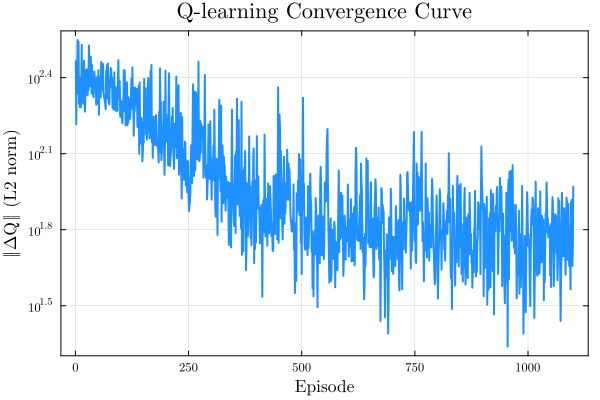

In [ ]:
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "Q-learning Convergence Curve",
    grid = :on,
    framestyle = :box
)

Benchmarking the Q_learning

In [ ]:
function benchmark_policy(policy, mdp; episodes=1_000_000, horizon=30, rng=MersenneTwister(42))
    total_rewards = zeros(episodes)

    for ep in 1:episodes
        s = 10  # start state
        ep_reward = 0.0

        for t in 1:horizon
            a = policy[s + 1]  # select action from learned policy
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)  # simulate next step
            ep_reward += r
            s = sp
        end

        total_rewards[ep] = ep_reward
    end

    mean_reward = mean(total_rewards)
    std_reward = std(total_rewards)

    return mean_reward, std_reward, total_rewards
end

benchmark_policy (generic function with 1 method)

Benchmark results for learned Q-learning policy:
  Mean total reward over episodes: -1399.121552
  Std. deviation: 359.81211735275275


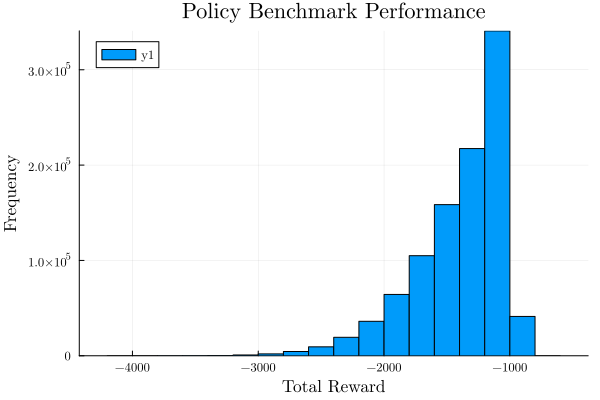

In [ ]:
policy = [argmax(Q[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
mean_r, std_r, rewards = benchmark_policy(policy, mdp)

println("Benchmark results for learned Q-learning policy:")
println("  Mean total reward over episodes: $mean_r")
println("  Std. deviation: $std_r")

using Plots
histogram(rewards, bins=30, xlabel="Total Reward", ylabel="Frequency", title="Policy Benchmark Performance")

In [ ]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

println("Starting benchmark for the Q_learning for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")
      Q = zeros(Float64, n_states, n_actions)
      Q, _ = my_Q_learing(mdp, α, ϵ, Q, epochs = 30, iterations = 1_000_0)
      π = [argmax(Q[s+1, :]) - 1 for s in states(mdp)]

      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         for t in 1:30
            a = π[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            # total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end


Starting benchmark for the Q_learning for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
α = 0.2 | ϵ = 0.1
α = 0.2 | ϵ = 0.01
α = 0.2 | ϵ = 1.0e-5
α = 0.1 | ϵ = 0.2
α = 0.1 | ϵ = 0.1
α = 0.1 | ϵ = 0.01
α = 0.1 | ϵ = 1.0e-5
α = 0.01 | ϵ = 0.2
α = 0.01 | ϵ = 0.1
α = 0.01 | ϵ = 0.01
α = 0.01 | ϵ = 1.0e-5
α = 1.0e-5 | ϵ = 0.2
α = 1.0e-5 | ϵ = 0.1
α = 1.0e-5 | ϵ = 0.01
α = 1.0e-5 | ϵ = 1.0e-5


In [ ]:
returns_mean

4×4 Matrix{Float64}:
 -1223.27  -1222.03  -1227.17  -1228.59
 -1220.88  -1226.49  -1227.12  -1219.91
 -1358.13  -1319.93  -1253.65  -1467.37
 -1727.04  -1906.98  -2244.05  -5578.39

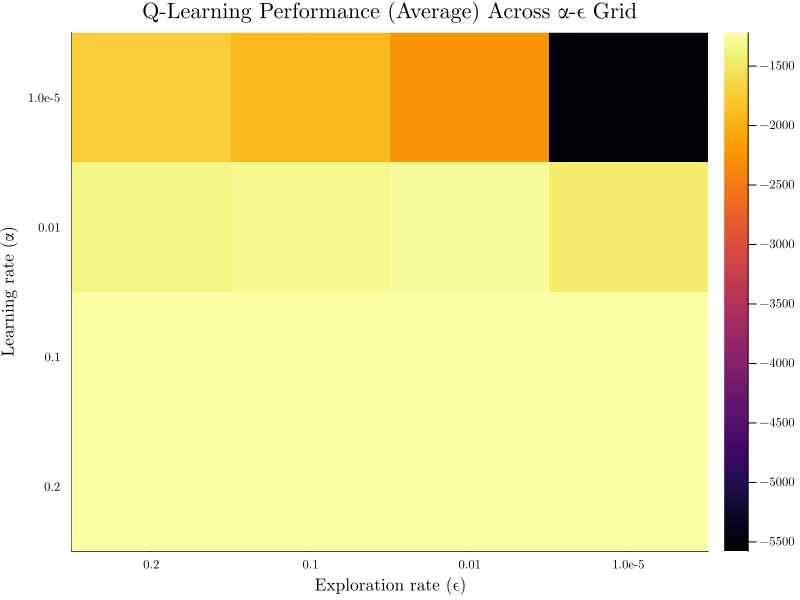

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

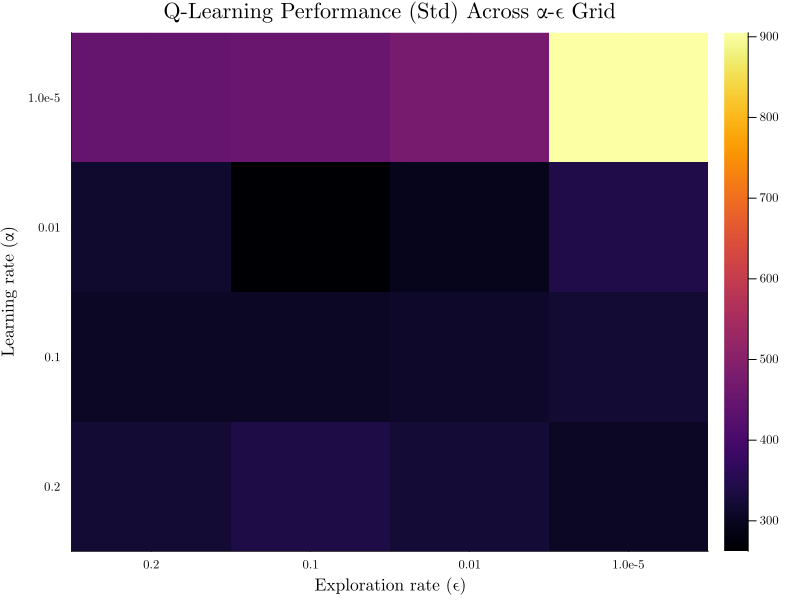

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 3 - SARSA Method

In [ ]:
function my_SARSA(mdp, α, ϵ, Q0; n_states = 21, n_actions = 2, epochs = 100, iterations = 10_000, s0 = 10, γ = 0.99)
    rng = MersenneTwister(12344)

    Q = copy(Q0)
    ERR = []

    for i in 1:iterations
        s = s0
        a = rand() < ϵ ? rand([0, 1]) : argmax(Q[s + 1, :]) - 1

        for t in 1:epochs
            sp, r, _ = POMDPs.gen(mdp, s, a, rng)
            ap = rand() < ϵ ? rand([0, 1]) : argmax(Q[sp + 1, :]) - 1

            Q[s + 1, a + 1] += α * (r + γ * Q[sp + 1, ap + 1] - Q[s + 1, a + 1])

            s = sp
            a = ap
        end

        if i % 10 == 0
            err = norm(Q - Q0)
            push!(ERR, err)
            Q0 .= Q
        end
    end

    return Q, ERR
end


my_SARSA (generic function with 1 method)

In [ ]:
s = 10
α = 0.1
ϵ = 0.1
Q = zeros(Float64, n_states, n_actions)
Q, ERR = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 1000)

([-3544.80119388215 -3378.274222599685; -3396.971206797241 -3403.7443094881523; … ; -2714.961411087841 -2695.1567625192984; -2457.6723467235342 -2441.385105400975], Any[628.035374738963, 445.370708718276, 435.70066580716326, 381.3427867733169, 412.8673939703162, 376.03766786067825, 435.5125543004216, 367.2799213619124, 327.7910043786897, 361.50814600372723  …  255.58947513626498, 192.4875917794383, 197.31173491917406, 218.85938423647926, 221.02078808090627, 218.98394214197177, 190.81113782754616, 188.54933517817236, 220.4576554793093, 231.2715049009173])

In [ ]:
s = 10
α = 0.1
ϵ = 0.01
Q, ERR2 = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 10000)

([-5228.168592343302 -5014.124835966032; -5119.011184122382 -4964.342640172122; … ; -4832.538316914475 -4856.382516454413; -4823.6178290502085 -4830.301327276212], Any[244.25906176694778, 208.657129445226, 193.64247395957958, 154.91304252096586, 211.80345071746413, 179.94911313605135, 230.54626532644332, 199.90694887784437, 155.9406135132732, 139.0177509357692  …  42.317710179853826, 63.07707910785904, 122.7966805654768, 82.87816709799053, 93.02282977841924, 65.05899970018798, 117.45756201776545, 49.70927321039418, 74.70167927410442, 92.05564399127371])

In [ ]:
for e in ERR2
    push!(ERR, e)
end

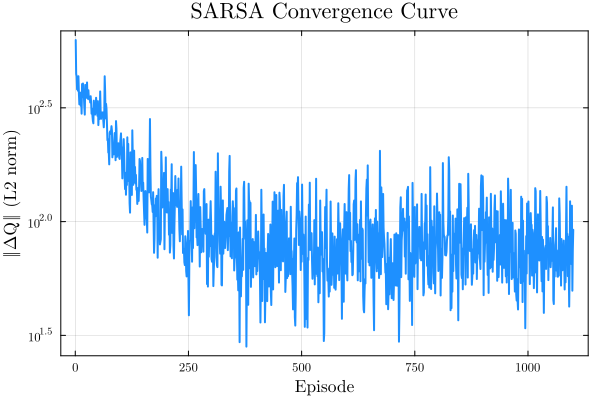

In [ ]:
plot(ERR;
    xlabel = "Episode",
    ylabel = "‖ΔQ‖ (L2 norm)",
    yscale = :log10,
    lw = 2,
    color = :dodgerblue,
    legend = false,
    title = "SARSA Convergence Curve",
    grid = :on,
    framestyle = :box
)


Benchmarking SARSA

In [ ]:
N_eval = 10_000
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean_sarsa = zeros(length(alphas), length(epsilons))
returns_std_sarsa = zeros(length(alphas), length(epsilons))

println("Starting benchmark for the SARSA for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
    for (j, ϵ) in enumerate(epsilons)
        println("α = $α | ϵ = $ϵ")
        Q = zeros(Float64, n_states, n_actions)
        Q, _ = my_SARSA(mdp, α, ϵ, Q, epochs = 30, iterations = 10_000)
        π = [argmax(Q[s+1, :]) - 1 for s in states(mdp)]

        total_rewards = zeros(N_eval)

        for k in 1:N_eval
            s = 10
            total_r = 0.0

            for t in 1:30
                a = π[s+1]
                s, r = POMDPs.gen(mdp, s, a, rng)
                total_r = r + total_r * 0.99
            end

            total_rewards[k] = total_r
        end

        mean_r = mean(total_rewards)
        std_r = std(total_rewards)

        returns_mean_sarsa[i, j] = mean_r
        returns_std_sarsa[i, j] = std_r
    end
end

Starting benchmark for the SARSA for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
α = 0.2 | ϵ = 0.1
α = 0.2 | ϵ = 0.01
α = 0.2 | ϵ = 1.0e-5
α = 0.1 | ϵ = 0.2
α = 0.1 | ϵ = 0.1
α = 0.1 | ϵ = 0.01
α = 0.1 | ϵ = 1.0e-5
α = 0.01 | ϵ = 0.2
α = 0.01 | ϵ = 0.1
α = 0.01 | ϵ = 0.01
α = 0.01 | ϵ = 1.0e-5
α = 1.0e-5 | ϵ = 0.2
α = 1.0e-5 | ϵ = 0.1
α = 1.0e-5 | ϵ = 0.01
α = 1.0e-5 | ϵ = 1.0e-5


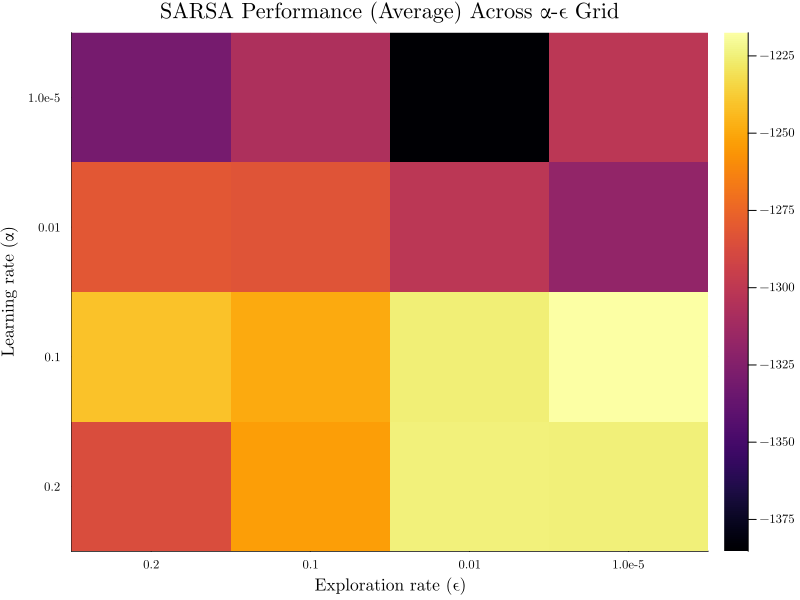

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

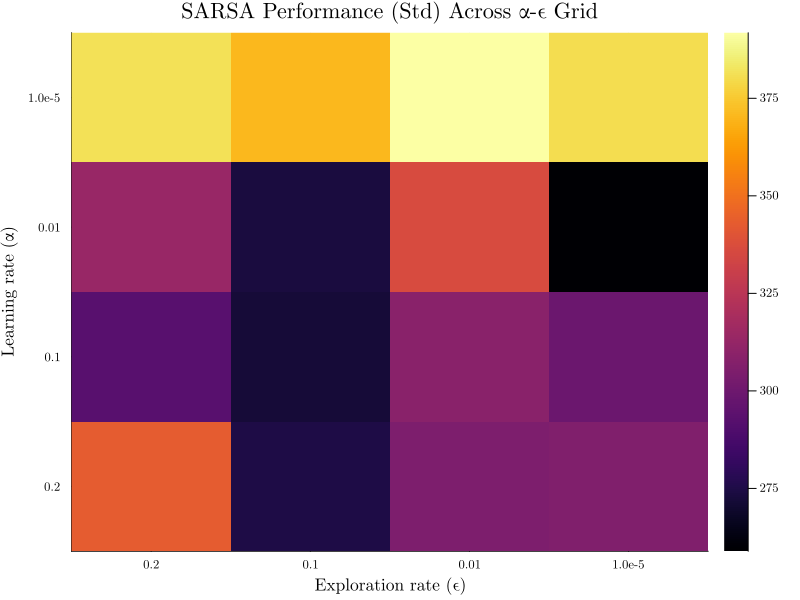

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_std_sarsa;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA Performance (Std) Across α-ϵ Grid",
    # c = :viridis,
)

# 4 - Comparison with POMDS.jl

In [ ]:
mdp_q3 = QuickMDP(
    states     = 0:MAX_INVENTORY,
    actions    = [0, 1],
    discount   = 0.99,

    gen = function (s, a, rng)
        order_qty = a == 1 ? min(ORDER_SIZE, MAX_INVENTORY - s) : 0
        new_stock = s + order_qty

        d = rand(rng, demand_dist)
        sold = min(d, new_stock)
        sp = new_stock - sold

        lost_sales = max(d - new_stock, 0)

        in_store = min(sp, MAX_STORE)
        in_parking = max(sp - MAX_STORE, 0)

        cost = 0
        cost += a == 1 ? order_cost : 0
        cost += in_store * holding_cost_store
        cost += in_parking * holding_cost_parking
        cost += lost_sales * stockout_penalty

        r = -cost

        return (sp=sp, r=r)
    end,

    initialstate = Deterministic(10)
)

QuickMDP{Base.UUID("92525382-3f45-42e6-87ca-e6945b39315b"), Int64, Int64, @NamedTuple{stateindex::Dict{Int64, Int64}, isterminal::Bool, actionindex::Dict{Int64, Int64}, initialstate::Deterministic{Int64}, states::UnitRange{Int64}, actions::Vector{Int64}, discount::Float64, gen::var"#170#171"}}((stateindex = Dict(5 => 6, 16 => 17, 7 => 8, 20 => 21, 12 => 13, 8 => 9, 17 => 18, 1 => 2, 19 => 20, 0 => 1…), isterminal = false, actionindex = Dict(0 => 1, 1 => 2), initialstate = Deterministic{Int64}(10), states = 0:20, actions = [0, 1], discount = 0.99, gen = var"#170#171"()))

QLearningSolver

In [ ]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))


function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the QLearningSolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      ql_solver   = QLearningSolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      ql_policy = solve(ql_solver,   mdp_q3)

      π_ql = policy_vector(ql_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_ql[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end

Starting benchmark for the QLearningSolver for :
alphas = [0.2, 0.1, 0.01, 1.0e-5]
epsilons = [0.2, 0.1, 0.01, 1.0e-5]
α = 0.2 | ϵ = 0.2
On Iteration 100, Returns: -1622.9908256605645
On Iteration 200, Returns: -1257.27953596793
On Iteration 300, Returns: -1291.8722719148557
On Iteration 400, Returns: -1246.4518431985107
On Iteration 500, Returns: -1472.5994796320392
On Iteration 600, Returns: -1507.398880026509
On Iteration 700, Returns: -1298.6449443259278
On Iteration 800, Returns: -1278.8278141643334
On Iteration 900, Returns: -1197.8080620083556
On Iteration 1000, Returns: -1307.2978675623833
On Iteration 1100, Returns: -1234.5087309932492
On Iteration 1200, Returns: -1197.673486172859
On Iteration 1300, Returns: -1357.3938427674896
On Iteration 1400, Returns: -1258.1348257578425
On Iteration 1500, Returns: -1235.3016585919393
On Iteration 1600, Returns: -1219.5240289392523
On Iteration 1700, Returns: -1233.7512969400927
On Iteration 1800, Returns: -1230.868261180667
On Iteration 

Excessive output truncated after 524309 bytes.

On Iteration 100, Returns: -1224.2110771557102
On Iteration 200, Returns: -1545.096717767243
On Iteration 300, Returns: -1474.5469489594655
On Iteration 400, Returns: -1680.7206138947472
On Iteration 500, Returns: -1657.5222525025774
On Iteration 600, Returns: -1381.5336444269976
On Iteration 700, Returns: -1645.8149882777768
On Iteration 800, Returns: -1418.323993796725
On Iteration 900, Returns: -1262.8423957956359
On Iteration 1000, Returns: -1321.6531733844145
On Iteration 1100, Returns: -1351.0372837839002
On Iteration 1200, Returns: -1781.633901848446
On Iteration 1300, Returns: -1492.7384185179906
On Iteration 1400, Returns: -1247.9387951408587
On Iteration 1500, Returns: -1292.2632930210166
On Iteration 1600, Returns: -1285.0653816786416
On Iteration 1700, Returns: -1575.446165359226
On Iteration 1800, Returns: -1232.1319312033577
On Iteration 1900, Returns: -1239.0138643495259
On Iteration 2000, Returns: -1587.002405112407
On Iteration 2100, Returns: -1423.443565044237
On Iter

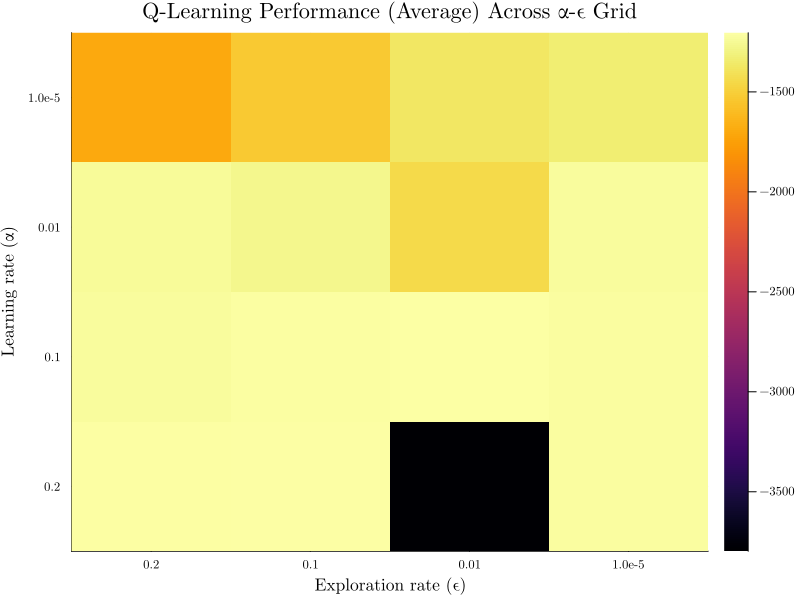

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "Q-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [ ]:
returns_mean

4×4 Matrix{Float64}:
 -1207.51  -1206.01  -3797.52  -1217.39
 -1226.04  -1211.74  -1204.28  -1215.98
 -1235.38  -1267.89  -1445.58  -1226.4
 -1700.46  -1530.6   -1372.07  -1332.33

SARSASolver

In [ ]:
N_eval = 1_000_0
alphas = [0.2, 0.1, 1e-2, 1e-5]
epsilons = [0.2, 0.1, 1e-2, 1e-5]
returns_mean = zeros(length(alphas), length(epsilons))
returns_std = zeros(length(alphas), length(epsilons))

function policy_vector(pol)
   [action(pol, s) for s in states(mdp_q3)]
end

println("Starting benchmark for the SARSASolver for :")

@show alphas
@show epsilons

for (i, α) in enumerate(alphas)
   for (j, ϵ) in enumerate(epsilons)
      println("α = $α | ϵ = $ϵ")

      sarsa_solver   = SARSASolver(
                 exploration_policy = EpsGreedyPolicy(mdp_q3, ϵ),
                 learning_rate      = α,
                 n_episodes         = 1_000_0,
                 max_episode_length = 30,
                 eval_every         = 100,
                 n_eval_traj        = 100)


      sarsa_policy = solve(sarsa_solver,   mdp_q3)

      π_sarsa = policy_vector(sarsa_policy)


      total_rewards = zeros(N_eval)

      for k in 1:N_eval
         s = 10
         total_r = 0.0

         rng =  MersenneTwister()
         for t in 1:30
            a = π_sarsa[s+1]
            s, r  = POMDPs.gen(mdp, s, a, rng)
            # s, r = out.sp, out.r
            total_r += r * discount(mdp)^(t - 1)
            # total_r += r
            # total_r = r +  total_r * 0.99
         end
         total_rewards[k] = total_r
      end

      mean_r = mean(total_rewards)
      std_r = std(total_rewards)
      # mean_r, std_r, rewards = benchmark_policy(π, mdp)
      returns_mean[i, j] = mean_r
      returns_std[i, j] = std_r

   end
end


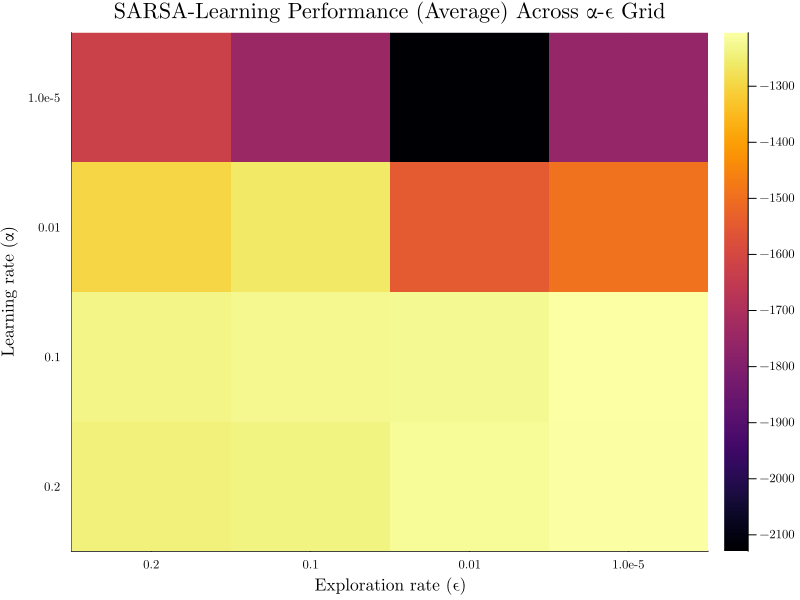

In [ ]:
heatmap(
    string.(epsilons),                 # x-ticks: exploration
    string.(alphas),                   # y-ticks: learning rates
    returns_mean;
    size = (800, 600),
    xlabel = "Exploration rate (ϵ)",
    ylabel = "Learning rate (α)",
    title = "SARSA-Learning Performance (Average) Across α-ϵ Grid",
    # c = :viridis,
)

In [ ]:
returns_mean

4×4 Matrix{Float64}:
 -1242.55  -1236.63  -1217.24  -1206.3
 -1233.68  -1225.59  -1223.8   -1204.66
 -1297.21  -1260.68  -1547.31  -1492.21
 -1626.56  -1743.47  -2129.24  -1755.7

# 5 - Optimal policy

## Value iteration

In [ ]:
function estimate_transitions_and_rewards(mdp; n_samples=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    P = [Dict{Int, Float64}() for s in 0:MAX_INVENTORY, a in 0:1]
    R = zeros(n_states, n_actions)

    rng = MersenneTwister(123)

    for s in 0:MAX_INVENTORY
        for a in 0:1
            outcomes = Dict{Int, Vector{Float64}}()

            for _ in 1:n_samples
                sp, r, _ = POMDPs.gen(mdp, s, a, rng)
                if !haskey(outcomes, sp)
                    outcomes[sp] = []
                end
                push!(outcomes[sp], r)
            end

            total_r = 0.0
            for (sp, rewards) in outcomes
                P[s+1, a+1][sp] = length(rewards) / n_samples
                avg_r = mean(rewards)
                total_r += avg_r * (length(rewards) / n_samples)
            end
            R[s+1, a+1] = total_r
        end
    end

    return P, R
end


estimate_transitions_and_rewards (generic function with 1 method)

In [ ]:
function value_iteration_tabular(P, R; γ=0.99, θ=1e-4, max_iters=1000)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    V = zeros(n_states)
    π = fill(0, n_states)

    for iter in 1:max_iters
        Δ = 0.0
        for s in 0:MAX_INVENTORY
            v = V[s+1]
            q_values = zeros(n_actions)

            for a in 0:1
                for (sp, p) in P[s+1, a+1]
                    q_values[a+1] += p * (R[s+1, a+1] + γ * V[sp+1])
                end
            end

            V[s+1] = maximum(q_values)
            π[s+1] = argmax(q_values) - 1
            Δ = max(Δ, abs(v - V[s+1]))
        end

        if Δ < θ
            println("Value Iteration Converged in $iter iterations.")
            break
        end
    end

    return V, π
end


value_iteration_tabular (generic function with 1 method)

In [ ]:
P, R = estimate_transitions_and_rewards(mdp)
V_opt, π_opt = value_iteration_tabular(P, R)

Q_sarsa, _ = my_SARSA(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
Q_qlearning, _ = my_Q_learing(mdp, 0.2, 0.3, zeros(Float64, n_states, n_actions))
π_sarsa = [argmax(Q_sarsa[s+1, :]) - 1 for s in 0:MAX_INVENTORY]
π_qlearning = [argmax(Q_qlearning[s+1, :]) - 1 for s in 0:MAX_INVENTORY]

21-element Vector{Int64}:
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 ⋮
 0
 0
 0
 0
 0
 1
 0
 0
 0

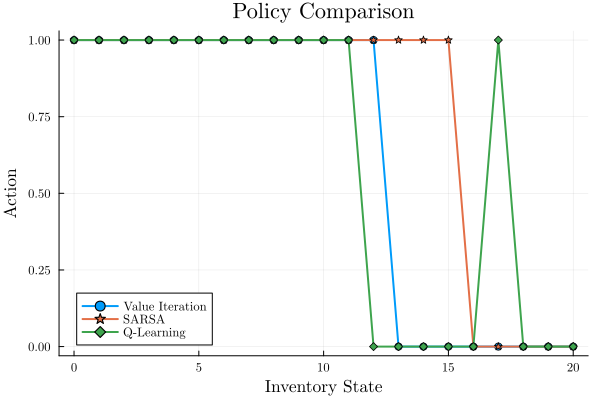

In [ ]:
states_range = 0:MAX_INVENTORY

plot(
    states_range, π_opt,
    label = "Value Iteration",
    lw = 2, marker = :circle,
    xlabel = "Inventory State",
    ylabel = "Action",
    title = "Policy Comparison"
)

plot!(states_range, π_sarsa, label = "SARSA", lw = 2, marker = :star5)
plot!(states_range, π_qlearning, label = "Q-Learning", lw = 2, marker = :diamond)


In [ ]:
println("Policy agreement with Value Iteration:")

println("SARSA agreement: ", sum(π_sarsa .== π_opt), "/", length(π_opt))
println("Q-Learning agreement: ", sum(π_qlearning .== π_opt), "/", length(π_opt))

## Linear programming formulation

In [ ]:
P, R = estimate_transitions_and_rewards(mdp)

([Dict(0 => 1.0) Dict(0 => 0.522, 4 => 0.1, 5 => 0.094, 2 => 0.092, 3 => 0.08, 1 => 0.112); Dict(0 => 0.9, 1 => 0.1) Dict(5 => 0.088, 4 => 0.098, 6 => 0.08, 0 => 0.468, 2 => 0.086, 3 => 0.093, 1 => 0.087); … ; Dict(16 => 0.09, 12 => 0.084, 17 => 0.094, 19 => 0.099, 11 => 0.09, 9 => 0.086, 14 => 0.073, 13 => 0.103, 15 => 0.092, 10 => 0.099…) Dict(16 => 0.076, 20 => 0.1, 12 => 0.101, 17 => 0.091, 19 => 0.093, 11 => 0.094, 14 => 0.095, 13 => 0.099, 15 => 0.078, 10 => 0.081…); Dict(16 => 0.095, 20 => 0.079, 12 => 0.093, 17 => 0.093, 19 => 0.09, 11 => 0.088, 14 => 0.096, 13 => 0.086, 15 => 0.094, 10 => 0.092…) Dict(16 => 0.078, 20 => 0.096, 12 => 0.101, 17 => 0.091, 19 => 0.087, 11 => 0.102, 14 => 0.091, 13 => 0.093, 15 => 0.09, 10 => 0.098…)], [-251.0 -86.262; -204.85 -69.00000000000001; … ; -36.34 -60.116000000000014; -39.83599999999999 -59.315999999999995])

In [ ]:
function solve_lp_mdp(P, R; γ=0.99)
    n_states = MAX_INVENTORY + 1
    n_actions = 2

    model = Model(GLPK.Optimizer)

    @variable(model, V[1:n_states])
    @objective(model, Min, sum(V))

    for s in 0:MAX_INVENTORY
        for a in 0:1
            lhs = 0.0
            for (sp, p) in P[s+1, a+1]
                lhs += p * (R[s+1, a+1] + γ * V[sp+1])
            end
            @constraint(model, V[s+1] >= lhs)
        end
    end

    optimize!(model)

    if termination_status(model) != MOI.OPTIMAL
        error("LP did not converge to an optimal solution.")
    end

    V_star = JuMP.value.(V)
    π_lp = fill(0, n_states)

    # Extract greedy policy from V*
    for s in 0:MAX_INVENTORY
        q_vals = zeros(n_actions)
        for a in 0:1
            for (sp, p) in P[s+1, a+1]
                q_vals[a+1] += p * (R[s+1, a+1] + γ * V_star[sp+1])
            end
        end
        π_lp[s+1] = argmax(q_vals) - 1
    end

    return V_star, π_lp
end

solve_lp_mdp (generic function with 1 method)

In [ ]:
V_lp, π_lp = solve_lp_mdp(P, R)

([-4918.370956776336, -4891.170994573723, -4862.937034869094, -4832.146885731768, -4811.688677952297, -4793.473632624285, -4782.211158967661, -4771.135926753872, -4762.451320679713, -4757.138855360043  …  -4749.66448197495, -4748.079444421711, -4743.1068578217055, -4736.881797219748, -4731.960680049711, -4729.749620803375, -4728.18464306976, -4727.484017468769, -4728.252062883714, -4729.293539737746], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

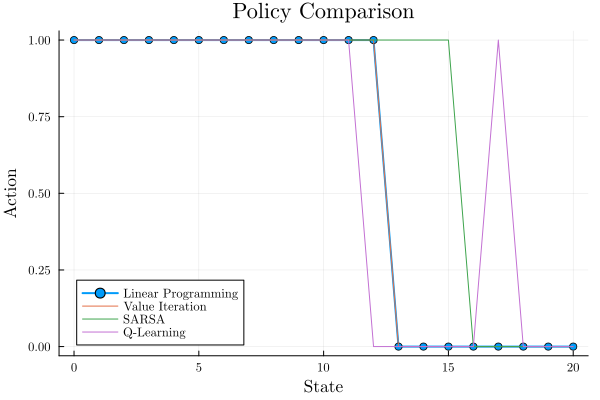

In [ ]:
plot(
    0:MAX_INVENTORY, π_lp,
    label = "Linear Programming",
    lw = 2, marker = :circle,
    title = "Policy Comparison",
    xlabel = "State",
    ylabel = "Action"
)
plot!(0:MAX_INVENTORY, π_opt, label = "Value Iteration")
plot!(0:MAX_INVENTORY, π_sarsa, label = "SARSA")
plot!(0:MAX_INVENTORY, π_qlearning, label = "Q-Learning")

In [ ]:
println("Agreement with LP-derived policy:")
println("SARSA: ", sum(π_sarsa .== π_lp), "/", length(π_lp))
println("Q-Learning: ", sum(π_qlearning .== π_lp), "/", length(π_lp))
println("Value Iteration: ", sum(π_opt .== π_lp), "/", length(π_lp))